#### Assignment 1 (4 scores): Implement PCA using Numpy.

Import dữ liệu

In [116]:
from google.colab import files

print("Vui lòng chọn file yalefaces.zip để tải lên.")
# Chọn file zip dữ liệu từ máy để tải lên
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'Bạn đã tải lên file "{fn}" với dung lượng {len(uploaded[fn])} bytes')

Vui lòng chọn file yalefaces.zip để tải lên.


Saving yalefaces.zip to yalefaces.zip
Bạn đã tải lên file "yalefaces.zip" với dung lượng 6168199 bytes


In [117]:
import os

# Giải nén file yalefaces.zip đã tải lên
# Lệnh -o là để overwrite (ghi đè) nếu có file trùng tên
!unzip -o /content/yalefaces.zip -d /content/

print("Đã giải nén thành công file dữ liệu yalefaces.zip")

# Cập nhật đường dẫn sau khi giải nén để phù hợp với cấu trúc trong file zip
train_path = "/content/yalefaces"
test_path = "/content/yalefaces/test"

# Kiểm tra thư mục chứa ảnh
print(f"Kiểm tra thư mục train: {train_path}")
print(f"Kiểm tra thư mục test: {test_path}")

if not os.path.exists(train_path):
    print(f"Thư mục train {train_path} không tồn tại sau khi giải nén.")
else:
    print(f"Nội dung trong thư mục train ({train_path}): {os.listdir(train_path)[:5]}...")

if not os.path.exists(test_path):
    print(f"Thư mục test {test_path} không tồn tại sau khi giải nén.")
else:
    print(f"Nội dung trong thư mục test ({test_path}): {os.listdir(test_path)[:5]}...")

Archive:  /content/yalefaces.zip
  inflating: /content/yalefaces/person-4/rightlight  
  inflating: /content/yalefaces/person-4/leftlight  
  inflating: /content/yalefaces/person-4/normal  
  inflating: /content/yalefaces/person-4/noglasses  
  inflating: /content/yalefaces/person-4/happy  
  inflating: /content/yalefaces/person-4/centerlight  
  inflating: /content/yalefaces/person-4/sleepy  
  inflating: /content/yalefaces/person-4/glasses  
  inflating: /content/yalefaces/person-4/wink  
  inflating: /content/yalefaces/person-4/surprised  
  inflating: /content/yalefaces/person-15/rightlight  
  inflating: /content/yalefaces/person-15/leftlight  
  inflating: /content/yalefaces/person-15/normal  
  inflating: /content/yalefaces/person-15/noglasses  
  inflating: /content/yalefaces/person-15/sad  
  inflating: /content/yalefaces/person-15/centerlight  
  inflating: /content/yalefaces/person-15/sleepy  
  inflating: /content/yalefaces/person-15/glasses  
  inflating: /content/yaleface

In [118]:
import os
import pandas as pd
import numpy as np
import imageio.v3 as iio
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from skimage.io import imread
from skimage.transform import resize
import random

Tiền xử lý dữ liệu ảnh

In [119]:
def load_and_display(folder_path, img_size=(64, 80), num_display=10):
    # Tải ảnh từ thư mục
    images, labels = [], []
    person_folders = [folder for folder in os.listdir(folder_path)
                     if os.path.isdir(os.path.join(folder_path, folder)) and folder != 'test']

    if not person_folders:
        print(f"Không tìm thấy thư mục nào trong {folder_path}!")
        return np.array(images), np.array(labels)

    print(f"Các thư mục tìm thấy: {person_folders}")

    for person_name in person_folders:
        person_path = os.path.join(folder_path, person_name)
        print(f"Đang xử lý thư mục: {person_name}")
        files = [f for f in os.listdir(person_path) if os.path.isfile(os.path.join(person_path, f))]
        if not files:
            print(f"Không tìm thấy tệp nào trong {person_path}!")
            continue

        print(f"Tệp trong {person_name}: {files[:3]}")
        for filename in files:
            img_path = os.path.join(person_path, filename)
            try:
                img = imread(img_path)

                # Sửa shape nếu ảnh dạng (1, H, W) hoặc (H, W, 1)
                if img.ndim == 3 and img.shape[0] == 1:
                    img = np.squeeze(img, axis=0)
                if img.ndim == 3 and img.shape[2] == 1:
                    img = np.squeeze(img, axis=2)
                if img.ndim == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                if img.ndim != 2:
                    raise ValueError(f"❌ Ảnh {img_path} không phải 2D, shape = {img.shape}")

                if img.dtype != np.uint8:
                    img = img.astype(np.uint8)

                img = cv2.equalizeHist(img)
                img = cv2.resize(img, img_size)
                img_processed = (img.astype(np.float32) / 255.0).flatten()
                images.append(img_processed)
                labels.append(person_name)
            except Exception as e:
                print(f"❌ Lỗi khi đọc ảnh: {img_path} - {e}")

    if not images:
        print("Không có ảnh nào được tải thành công!")
        return np.array(images), np.array(labels)

    # Hiển thị ảnh từ một thư mục ngẫu nhiên
    person_folder = random.choice(person_folders)
    print(f"Chọn thư mục để hiển thị: {person_folder}")

    plt.figure(figsize=(10, 5))
    person_path = os.path.join(folder_path, person_folder)
    files = [f for f in os.listdir(person_path) if os.path.isfile(os.path.join(person_path, f))]

    for ith, filename in enumerate(files):
        if ith >= num_display:  # Giới hạn số ảnh hiển thị
            break
        image_path = os.path.join(folder_path, person_folder, filename)
        try:
            image = imread(image_path)
            # Xử lý chiều ảnh tương tự như trên
            if image.ndim == 3 and image.shape[0] == 1:
                image = np.squeeze(image, axis=0)
            if image.ndim == 3 and image.shape[2] == 1:
                image = np.squeeze(image, axis=2)
            if image.ndim == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            if image.ndim != 2:
                raise ValueError(f"❌ Ảnh {image_path} không phải 2D, shape = {image.shape}")

            image = resize(image, img_size, anti_aliasing=True)
            plt.subplot(2, 5, ith + 1)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.title(filename)
        except Exception as e:
            print(f"❌ Lỗi khi hiển thị ảnh {image_path}: {e}")

    plt.tight_layout()
    plt.show()

    return np.array(images), np.array(labels)

In [120]:
def load_test_images(folder_path, img_size=(64, 80)):
    images, filenames = [], []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = iio.imread(img_path, index=0)
            if img.dtype == np.uint8 and img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            if img.ndim == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img.ndim != 2:
                raise ValueError(f"Ảnh {img_path} không phải 2D là sau khi xử lý")
            img = cv2.equalizeHist(img)
            img = cv2.resize(img, img_size)
            images.append((img.flatten().astype(np.float32)) / 255.0)
            filenames.append(filename)
        except Exception as e:
            print(f"Lỗi khi đọc ảnh test: {img_path} - {e}")
    return np.array(images), filenames

Khởi tạo PCA

In [121]:
class PCA:
    def __init__(self, d_principle: int = 1):
        self.d_principle = d_principle

    def fit(self, X: np.ndarray):
        # Trừ trung bình
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Ma trận hiệp phương sai
        cov = X_centered.T @ X_centered

        # Eigen decomposition (dùng eigh thay vì eig để đảm bảo số thực)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Điều chỉnh hướng vector
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]
        eigenvectors = eigenvectors.T

        # Sắp xếp eigenvalues giảm dần
        eigen_pairs = [(eigenvalues[i], eigenvectors[i, :]) for i in range(eigenvectors.shape[0])]
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

        # Lưu thành phần chính
        self._principle_values = np.array([v for v, _ in eigen_pairs[:self.d_principle]])
        self._W = np.array([vec for _, vec in eigen_pairs[:self.d_principle]])

    def transform(self, X: np.ndarray) -> np.ndarray:
        X_centered = X - self.mean
        return X_centered @ self._W.T

Visualizing eigenfaces

In [122]:
def show_eigenfaces(components, img_shape=(64, 80), num_eigenfaces=20):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_eigenfaces, components.shape[0])):
        eigenface = components[i].reshape(img_shape)
        # Kiểm tra giá trị hợp lệ
        if np.isnan(eigenface).any() or np.isinf(eigenface).any():
            print(f"Eigenface {i+1} chứa giá trị không hợp lệ (NaN/Inf), bỏ qua.")
            eigenface = np.zeros(img_shape)
        else:
            if eigenface.max() == eigenface.min():
                eigenface = np.zeros_like(eigenface)
            else:
                eigenface = (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface))
        plt.subplot(2, num_eigenfaces // 2, i + 1)
        plt.imshow(eigenface, cmap='gray')
        plt.title(f'Eigenface {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

In [123]:
import os

# Đảm bảo các thư mục yalefaces đã được tải lên và giải nén (nếu cần) vào /content/
train_path = "/content/yalefaces"
test_path = "/content/yalefaces/test"

# Kiểm tra xem BASE_DIR có tồn tại không
if not os.path.exists(train_path):
    print(f"Thư mục {train_path} không tồn tại! Kiểm tra lại đường dẫn, đảm bảo đường dẫn chính xác")
if not os.path.exists(test_path):
    print(f"Thư mục {test_path} không tồn tại! Kiểm tra lại đường dẫn, đảm bảo đường dẫn chính xác")

Load tập train:
Các thư mục tìm thấy: ['person-5', 'person-6', 'person-11', 'person-8', 'person-4', 'person-13', 'person-12', 'person-7', 'person-14', 'person-2', 'person-15', 'person-1', 'person-3', 'person-10', 'person-9']
Đang xử lý thư mục: person-5
Tệp trong person-5: ['glasses', 'happy', 'sleepy']
Đang xử lý thư mục: person-6
Tệp trong person-6: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-11
Tệp trong person-11: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-8
Tệp trong person-8: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-4
Tệp trong person-4: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-13
Tệp trong person-13: ['glasses', 'happy', 'sleepy']
Đang xử lý thư mục: person-12
Tệp trong person-12: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-7
Tệp trong person-7: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-14
Tệp trong person-14: ['wink', 'glasses', 'happy']
Đang xử lý thư mục: person-2
Tệp trong person-2: ['wink', 'gl

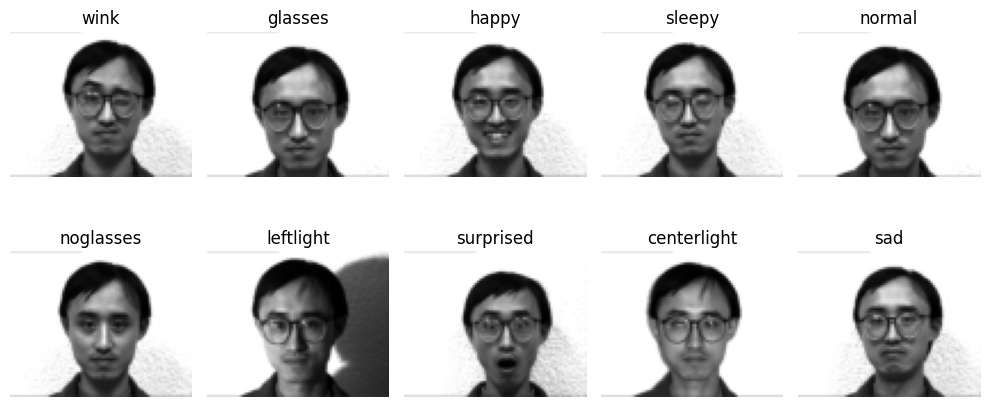

Số lượng ảnh train: 150
Giá trị min của X_train: 0.0
Giá trị max của X_train: 1.0
Kích thước của X_train: (150, 5120)


In [124]:
print("Load tập train:")
X_train, y_train = load_and_display(train_path, img_size=(64, 80))
print(f"Số lượng ảnh train: {len(X_train)}")

# Kiểm tra dữ liệu của tập train
print("Giá trị min của X_train:", X_train.min())
print("Giá trị max của X_train:", X_train.max())
print("Kích thước của X_train:", X_train.shape)

In [125]:
# Chuẩn hóa tập train và train model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(d_principle=20) # Ở đây sau khi thử nghiệm nhiều lần thì em thấy 20 thành phần chính đã bắt được phần lớn phương sai mà vẫn giữ được hiệu quả tính toán
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

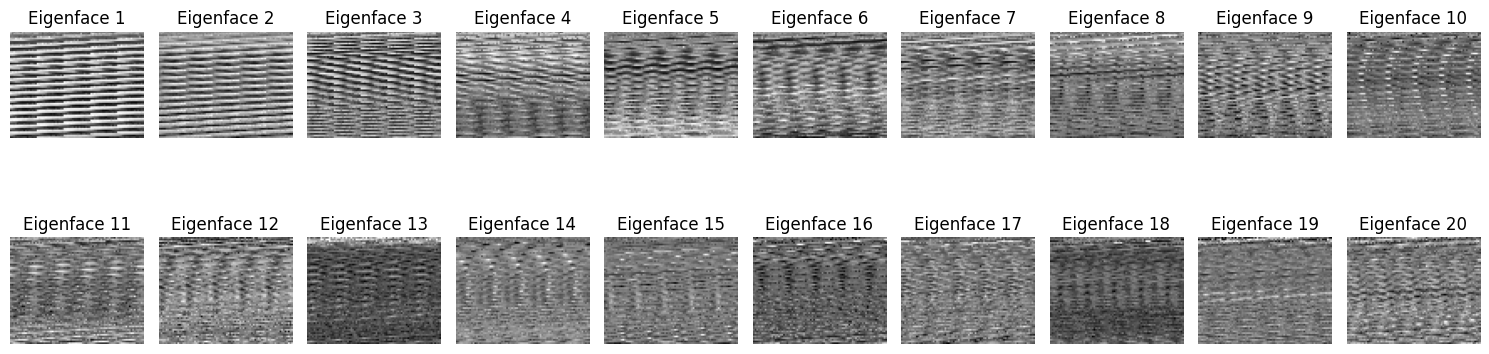

In [126]:
eigenfaces = pca._W
show_eigenfaces(eigenfaces, img_shape=(64, 80), num_eigenfaces=20)

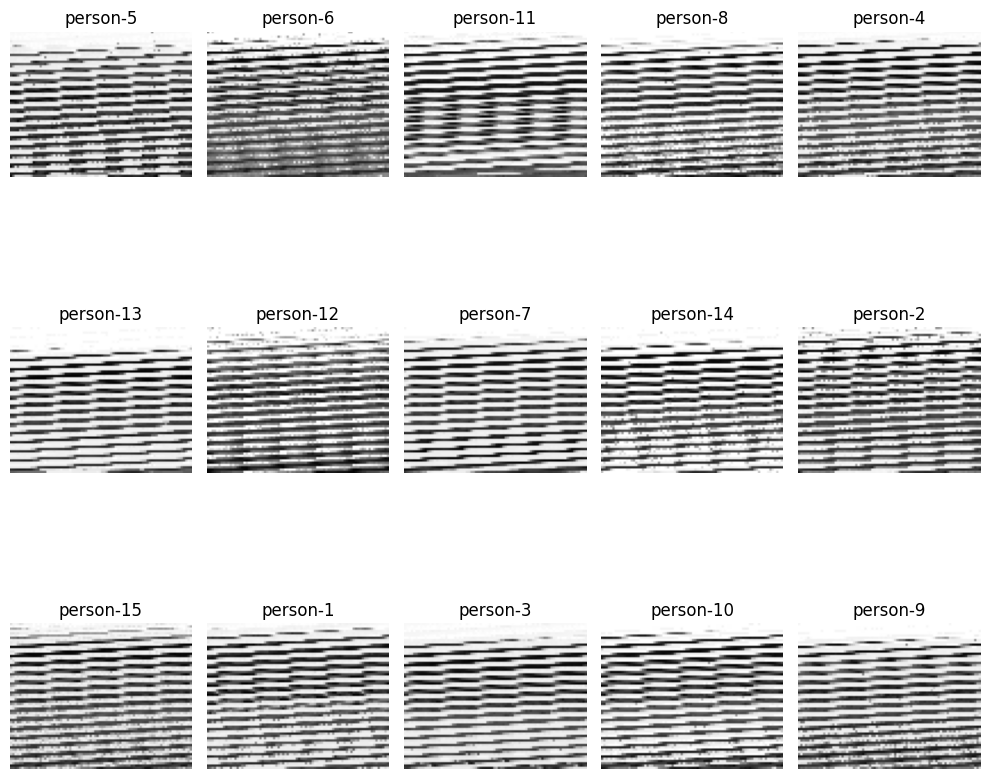

In [127]:
# Tìm mean face
data_by_person = defaultdict(list)
for img, label in zip(X_train, y_train):
    data_by_person[label].append(img)

# Tính mean face cho từng người
mean_faces = {
    person: np.mean(images, axis=0) for person, images in data_by_person.items()
}

# Vẽ mean faces
plt.figure(figsize=(10, 10))
for ith, (person, mean_face) in enumerate(mean_faces.items()):
    mean_face = mean_face.reshape(64, 80)
    plt.subplot(3, 5, ith+1)
    plt.imshow(mean_face, cmap='gray')
    plt.axis('off')
    plt.title(person)
plt.tight_layout()
plt.show()

In [128]:
projected_mean_faces = {}
for person, mean_face in mean_faces.items():
    mean_face_std = scaler.transform([mean_face])
    projected = pca.transform(mean_face_std.reshape(1, -1))  # reshape về (1, d)
    projected_mean_faces[person] = projected

#### Assignment 3 (2 scores):
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

In [129]:
# Load ảnh test và filename
test_images, test_filenames = load_test_images(test_path, img_size=(64, 80))

# Lấy nhãn từ tên file
labels = [filename.split('.')[0] for filename in test_filenames]

test_images_std = scaler.transform(test_images)

In [130]:
def Euclidean_distance(X: np.ndarray, Y: np.ndarray):
    assert X.shape == Y.shape, f"{X.shape} and {Y.shape} are mismatched"
    return np.sqrt(((X - Y) ** 2).sum())

def normalize(vec):
    return vec / (np.linalg.norm(vec) + 1e-8)

In [131]:
predictions = {}
for label, image in zip(labels, test_images_std):
    image = image.reshape(-1)
    projected_face = pca.transform(image.reshape(1, -1))[0]
    projected_face = normalize(projected_face)

    closest_person = None
    closest_distance = float('inf')

    for person, mean_face in projected_mean_faces.items():
        mean_face = normalize(mean_face.reshape(-1))
        distance = Euclidean_distance(projected_face, mean_face)
        if distance < closest_distance:
            closest_distance = distance
            closest_person = person

    predictions[label] = closest_person

In [132]:
correct = [label == predictions[label] for label in predictions]
accuracy = np.mean(correct) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 73.33%
